# fastbaps

In [2]:
#install.packages("devtools")
#devtools::install_github('gtonkinhill/fastbaps')
library(fastbaps)
library(ape)
library(mclust)     # for adjustedRandIndex
source('drawtrees.R')

In [3]:
meta <- read.table('/storage/btbgenie/all_ireland_results/metadata.csv',
                     sep=',',header=TRUE,row.names=1,comment.char="")
meta[] <- lapply(meta, as.character)
 
meta$clades <- paste(meta$IE_clade,meta$GB_clade)
#tree <- read.tree('../all_ireland_results/tree.newick')
#tree <- read.tree('../all_ireland_results/iqtree.newick')
tree <- read.tree('../all_ireland_results/tree_raxml.newick')
#tree <- root(tree,'ref')
alnfile <- '../all_ireland_results/core.fa'

In [4]:
tree


Phylogenetic tree with 5876 tips and 5874 internal nodes.

Tip labels:
  ERR4627336, ERR4627331, ERR4627333, ERR4627332, ERR4627334, ERR4627330, ...
Node labels:
  , 58, 85, 100, 100, 100, ...

Unrooted; includes branch length(s).

## partition on core alignment

In [ ]:
sparse.data <- import_fasta_sparse_nt(alnfile)
sparse.data <- optimise_prior(sparse.data, type="optimise.symmetric")
#baps.hc <- fast_baps(sparse.data)
#clusters <- best_baps_partition(sparse.data, as.phylo(baps.hc))
multi <- multi_res_baps(sparse.data, levels=3, n.cores=8)
#save(multi,file="fastbaps_multi.rda")

In [21]:
#multi

In [19]:
m1 <- data.frame(multi, id = colnames(sparse.data$snp.matrix), stringsAsFactors = FALSE)
rownames(m1) <- m2$Isolates
#write.table(m1,'../all_ireland_results/fastbaps_m1clades.csv',sep=',')

## partition an existing tree

In [5]:
sparse.data <- import_fasta_sparse_nt(alnfile, prior = "baps")
tree.rooted <- phytools::midpoint.root(tree)
#tree.rooted <- phytools::reroot(tree, 'ref')
multi2 <- multi_level_best_baps_partition(sparse.data, tree.rooted, levels=3, n.cores=12)

In [7]:
m2 <- data.frame(multi2, id = colnames(sparse.data$snp.matrix), stringsAsFactors = FALSE)
rownames(m2) <- m2$Isolates
#write.table(m2,'../all_ireland_results/fastbaps_m2clades.csv',sep=',')

In [8]:
cat("unique Level3 groups =", length(unique(m2$Level.3)), "\n")

unique Level3 groups = 282 


In [ ]:
options(repr.plot.width=20, repr.plot.height=11) 
p <- ggtree(tree)
f <- facet_plot(p, panel = "m1", data = m1, geom = geom_tile, 
        aes(x = Level.1), color = "blue")
f <- facet_plot(f, panel = "m2", data = m2, geom = geom_tile, 
        aes(x = Level.1), color = "red")
f

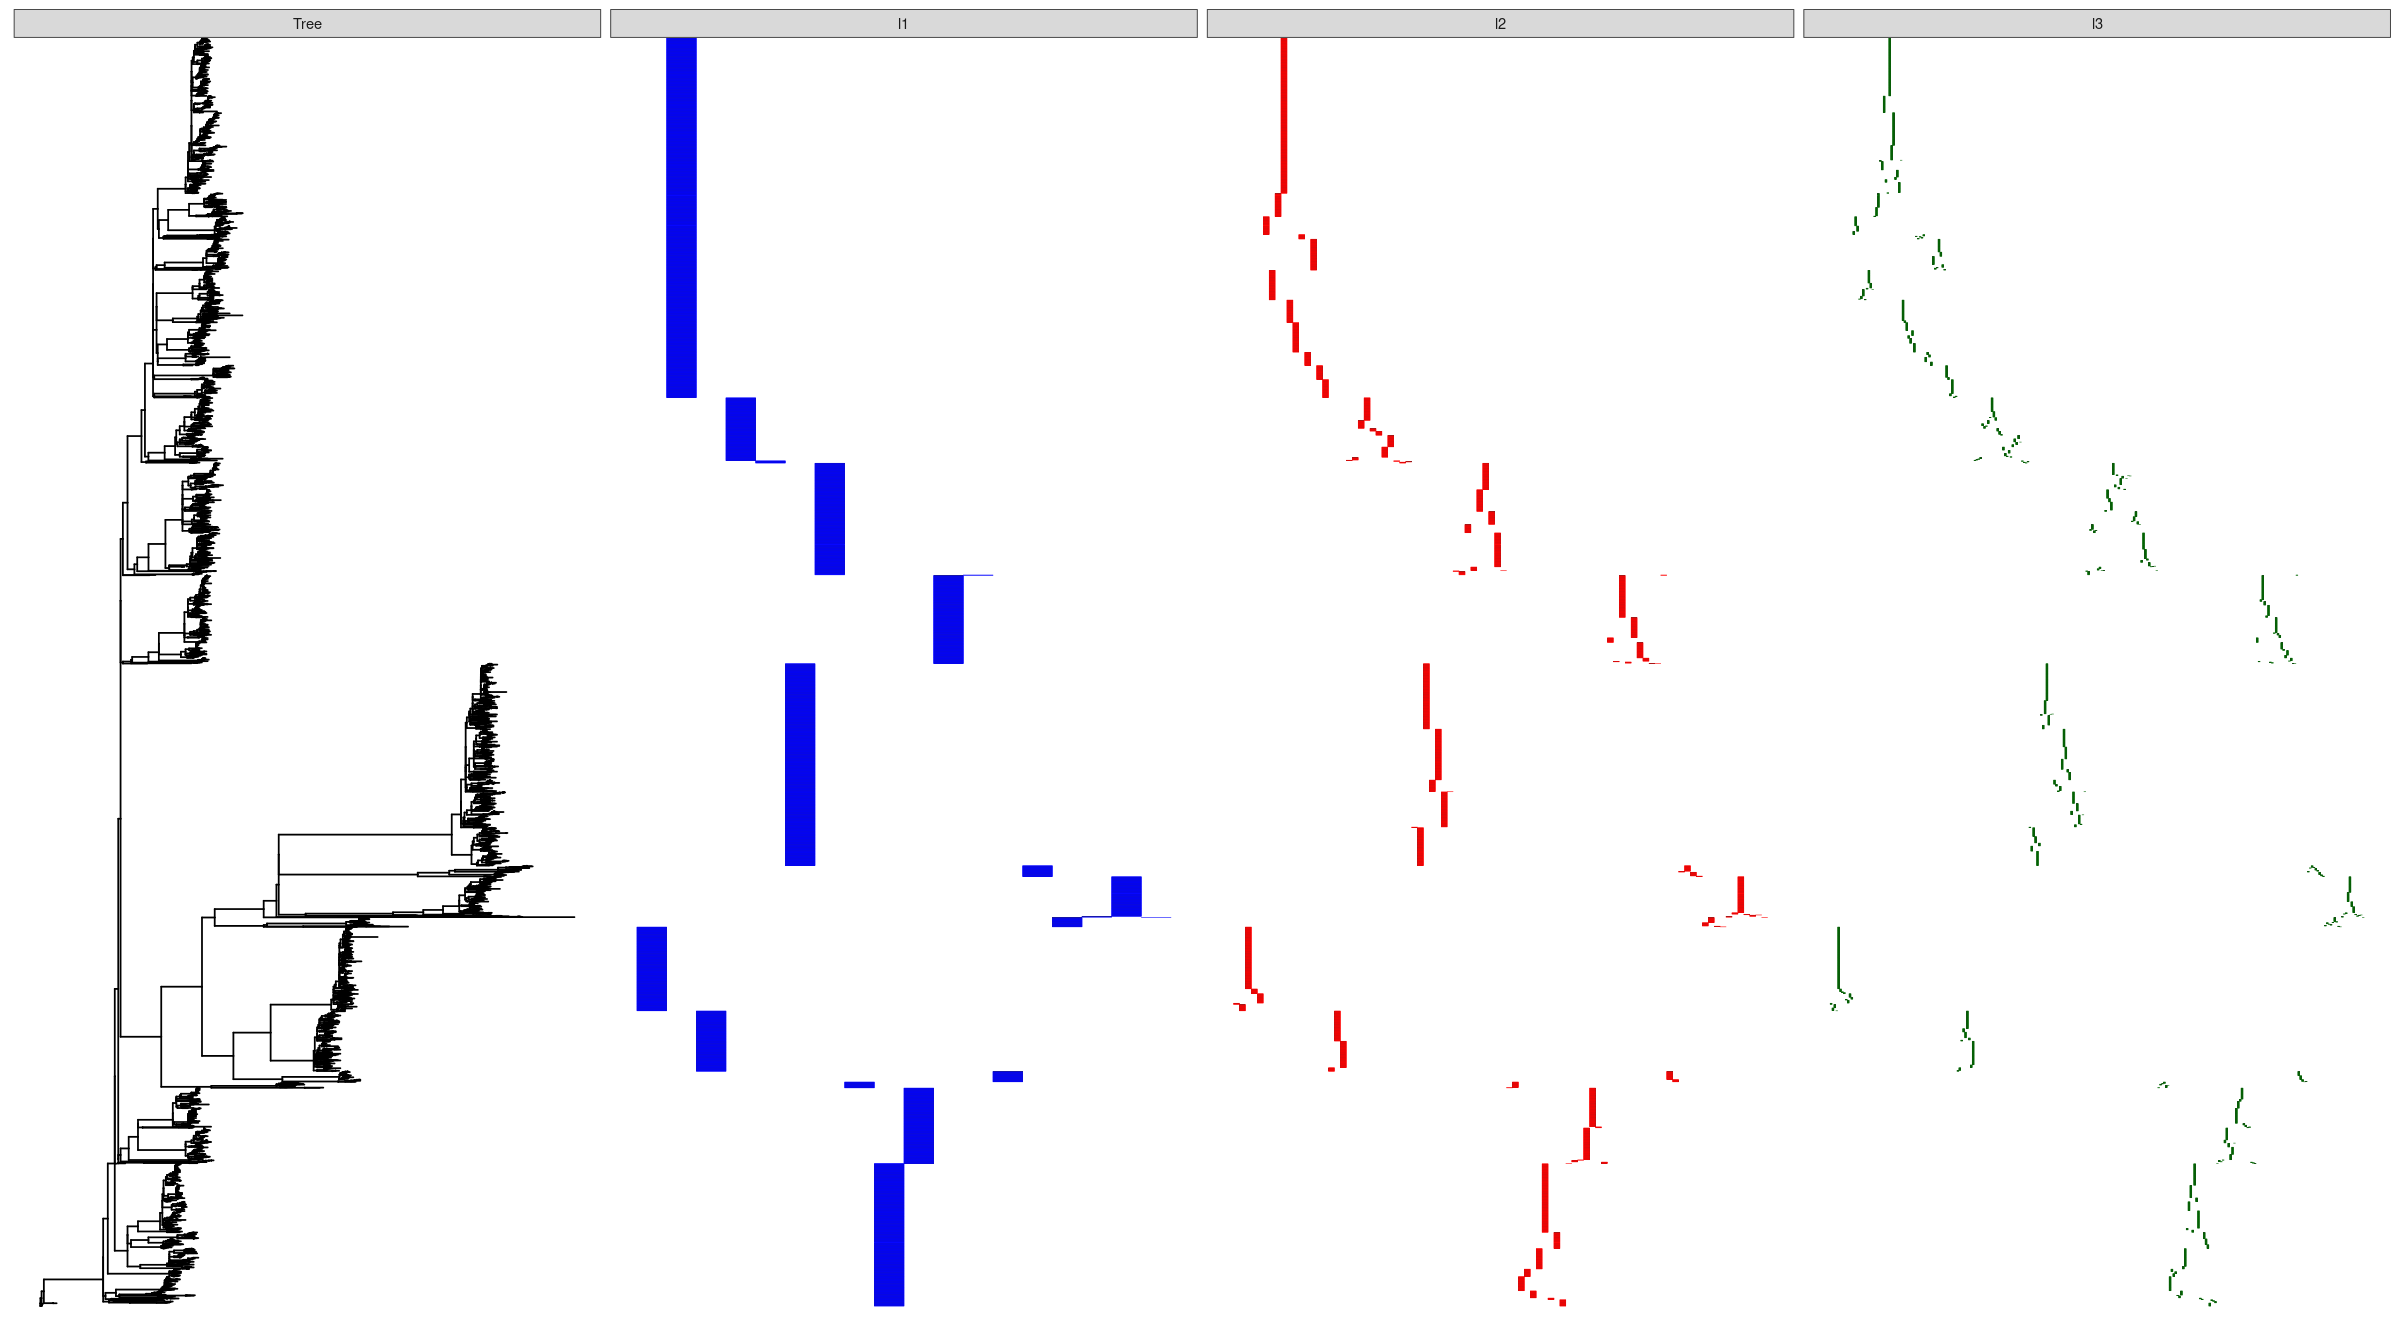

In [10]:
options(repr.plot.width=20, repr.plot.height=11) 
p <- ggtree(tree)
f <- facet_plot(p, panel = "l1", data = m2, geom = geom_tile, 
        aes(x = Level.1), color = "blue")
f <- facet_plot(f, panel = "l2", data = m2, geom = geom_tile, 
        aes(x = Level.2), color = "red")
f <- facet_plot(f, panel = "l3", data = m2, geom = geom_tile, 
        aes(x = Level.3), color = "darkgreen")
f

In [23]:
master <- merge(m1, m2, by.x = 1, by.y = 1)
master <- merge(meta[,1:6], master, by.x = 0, by.y = 1)
rownames(master) <- master[,1]
master[] <- lapply(master, as.character)

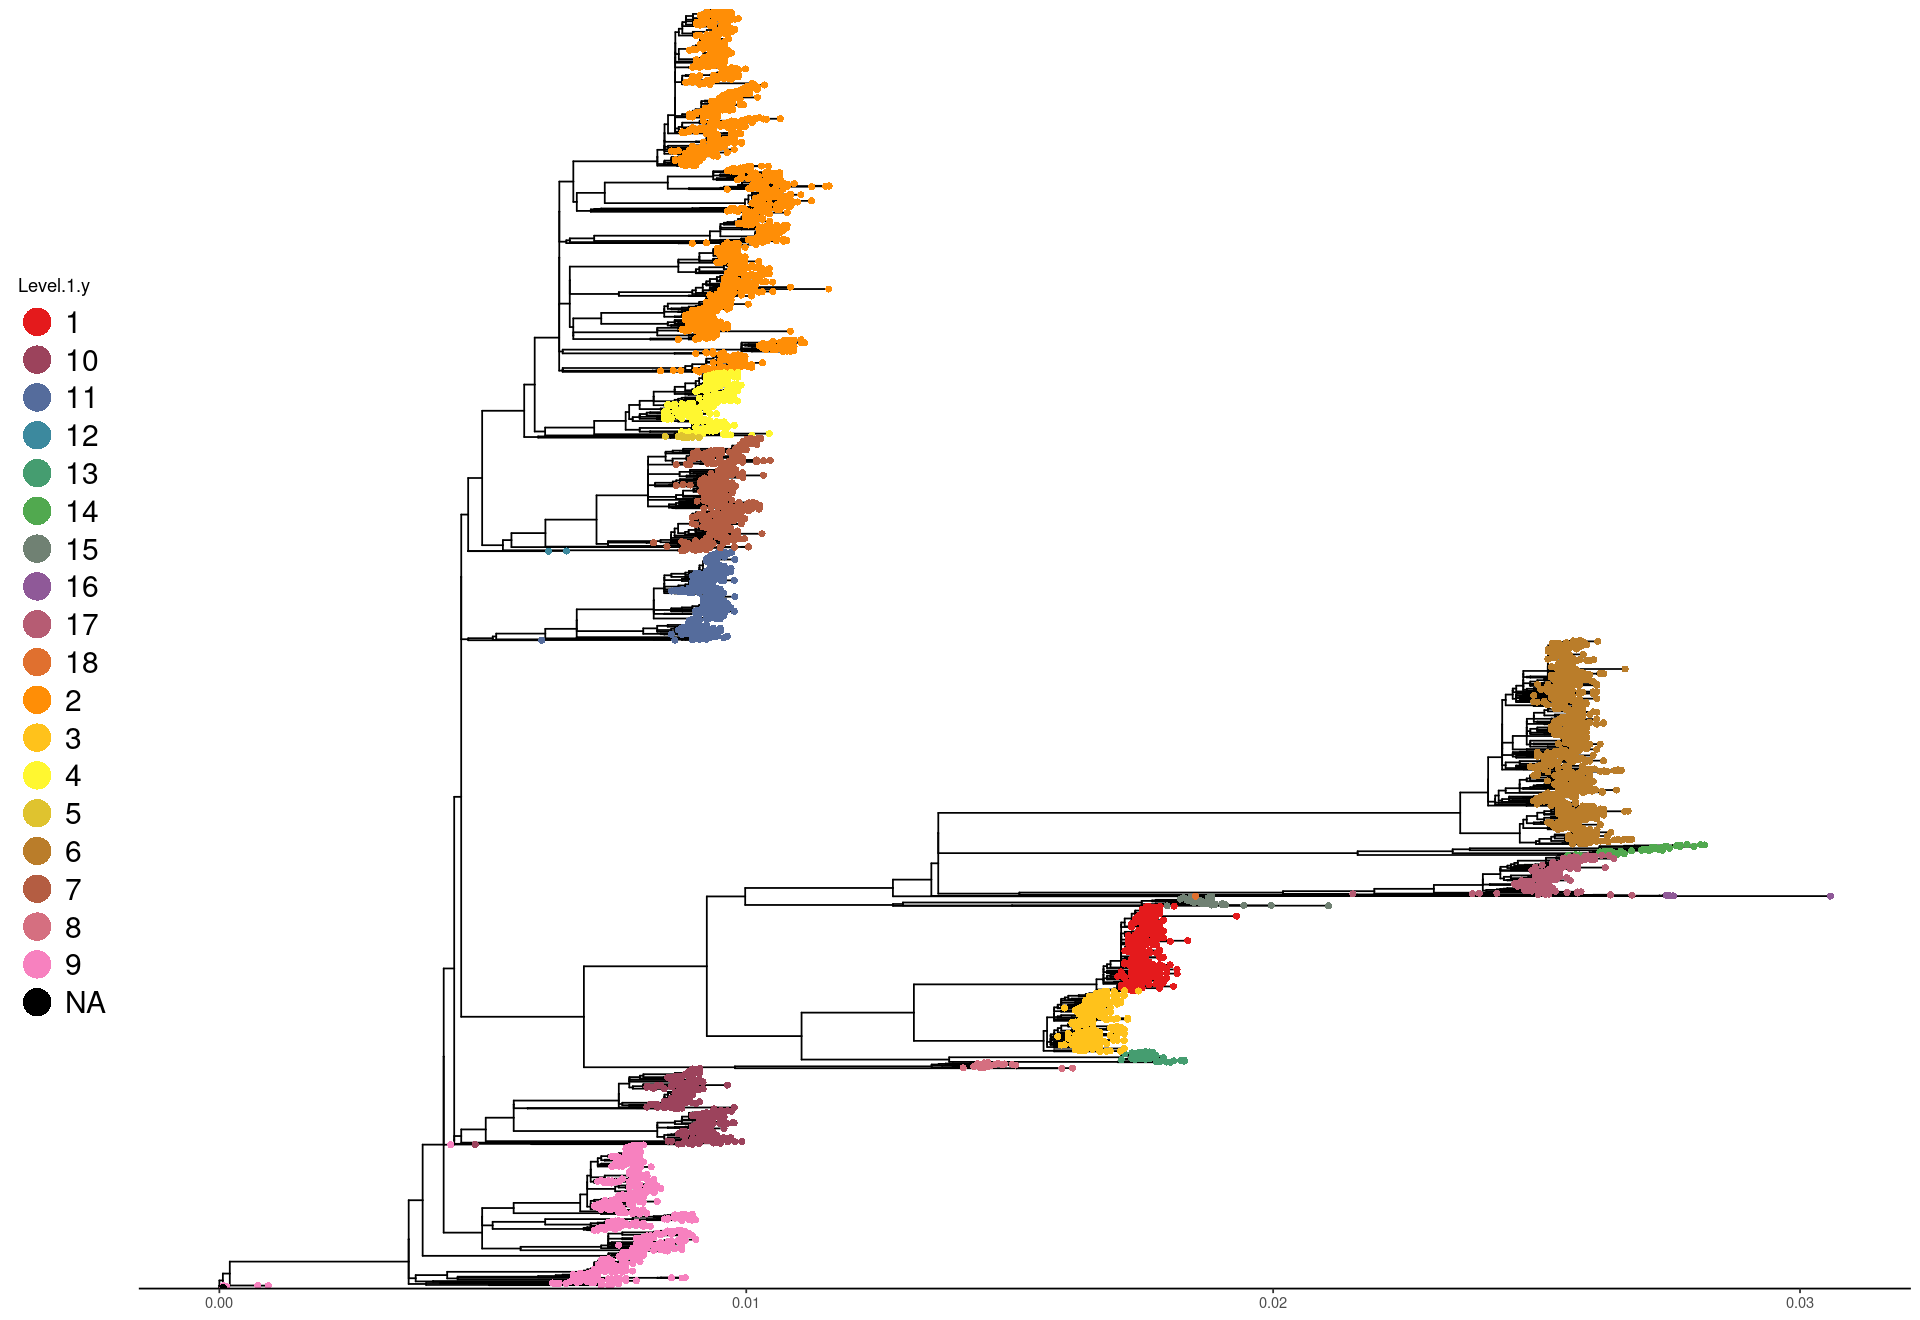

In [26]:
options(repr.plot.width=16, repr.plot.height=11) 
ggplottree(tree, master, layout='rect', cols=c('Level.1.y'),cmaps=c('Set1','Set2'),
           tipsize=2, tiplabelsize=4,tipoffset=.5, offset=.01) #+ xlim(NA,800)

In [ ]:
options(repr.plot.width=16, repr.plot.height=11) 
stree <- prune_tree(tree, 200)
ggplottree(stree, master, layout='cladogram', cols=c('Level.1.x','Level.1.y'),cmaps=c('Set1','Set2','Set1'),#legend=FALSE,
           tipsize=.1, tiplabelsize=4,tipoffset=.5, offset=5) #+ xlim(NA,800)

In [ ]:
options(repr.plot.width=16, repr.plot.height=14)
uniq <- row.names(distinct(meta,Level.1,.keep_all = TRUE))
gb <- rownames(meta[meta$Region=='GB',])
ni <- rownames(meta[meta$Region=='NI',])
keep <- paste(c(uniq,gb))
#print (keep)
stree <- keep.tip(tree, keep)
ggplottree(stree,meta,layout='c',cols=c('Region','Level.1'),
            tipsize=3, offset=.005,cmaps=c('Dark2','Set1'),
            tiplabelcol='clades', tiplabel=TRUE, tiplabelsize=3, tipoffset=.001,align=TRUE)

## test robustness of clades (at level.3 - strains)

In [49]:
boot.result <- boot_fast_baps(sparse.data)
dendro <- as.dendrogram(fast_baps(sparse.data))
heatmap.2(boot.result, dendro, dendro, tracecol = NA)

[1] "Calculating initial clustering..."
[1] "Calculating initial dk values..."
[1] "Clustering using hierarchical Bayesian clustering..."


ERROR: Error in heatmap.2(boot.result, dendro, dendro, tracecol = NA): could not find function "heatmap.2"


In [19]:
n.reps<-3
n.cores<-12
# Reference clustering
ref <- multi_level_best_baps_partition(sparse.data, tree.rooted, levels = 3)
ref_df <- data.frame(ref)
rownames(ref_df)<- ref$Isolates
ref_l3 <- ref_df[,"Level.3"]
print (head(ref_df))

In [ ]:
# Permutation test
set.seed(42)
n.reps <- 10
ARI <- numeric(n.reps)

for (i in 1:n.reps) {
  perm_order <- sample(ncol(sparse.data$snp.matrix))
  print (head(perm_order))
  sparse_perm <- sparse.data
  sparse_perm$snp.matrix <- sparse.data$snp.matrix[, perm_order, drop = FALSE]
  colnames(sparse_perm$snp.matrix) <- colnames(sparse.data$snp.matrix)[perm_order]

  perm <- multi_level_best_baps_partition(sparse_perm, tree.rooted, levels=3)
  
  perm_df <- data.frame(perm)
  rownames(perm_df)<- perm_df$Isolates
  perm_df <- perm_df[row.names(ref_df),]
  perm_l3 <- perm_df[,"Level.3"]   
  print (head(perm_df))
    
  ARI[i] <- adjustedRandIndex(ref_l3, perm_l3)
  message("Run ", i, " ARI = ", ARI[i])
}

print(ARI)